<a href="https://colab.research.google.com/github/sudhanwa755/google-colab-project-/blob/main/Stock_Prediction_using_Linear_Regression_final_TAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Step 1: Data loaded
         Date  Open  High   Low  Close(t)     Volume      SD20  Upper_Band  \
0 2005-10-17  6.66  6.69  6.50      6.60  154208600  0.169237    6.827473   
1 2005-10-18  6.57  6.66  6.44      6.45  152397000  0.168339    6.819677   
2 2005-10-19  6.43  6.78  6.32      6.78  252170800  0.180306    6.861112   
3 2005-10-20  6.72  6.97  6.71      6.93  339440500  0.202674    6.931847   
4 2005-10-21  7.02  7.03  6.83      6.87  199181500  0.216680    6.974860   

   Lower_Band  S_Close(t-1)  ...  QQQ_MA10  QQQ_MA20  QQQ_MA50  SnP_Close  \
0    6.150527          6.67  ...    33.692   33.9970   34.2690    1190.10   
1    6.146323          6.60  ...    33.570   33.9525   34.2466    1178.14   
2    6.139888          6.45  ...    33.562   33.9600   34.2330    1195.76   
3    6.121153          6.78  ...    33.567   33.9455   34.2190    1177.80   
4    6.108140          6.93  ...    33.586   33.9365   34.2034    1179.59   

   SnP(t-1))  SnP(t-5)  DJIA_Close  DJIA(t-1))  DJI

<ipython-input-5-6c4688c3171e>:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill to handle NaNs


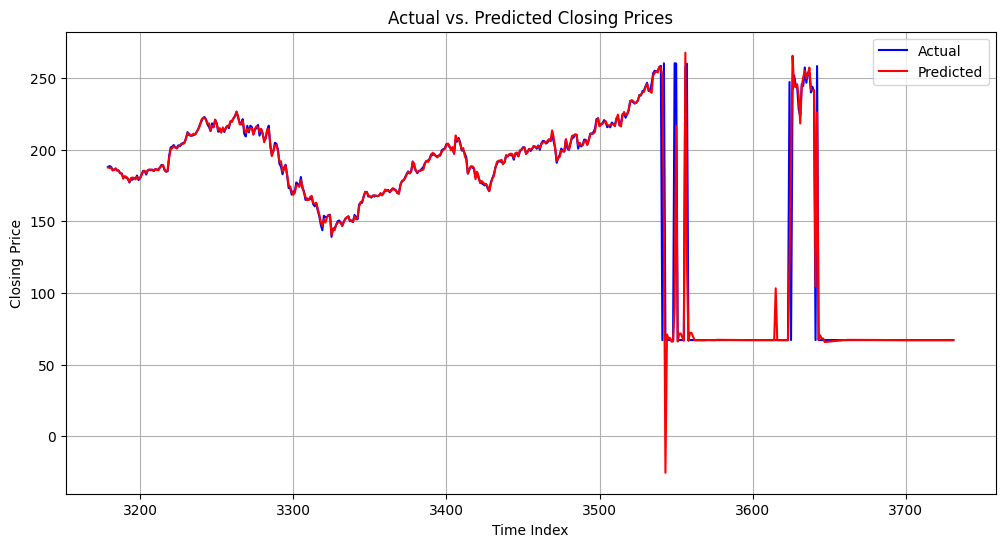

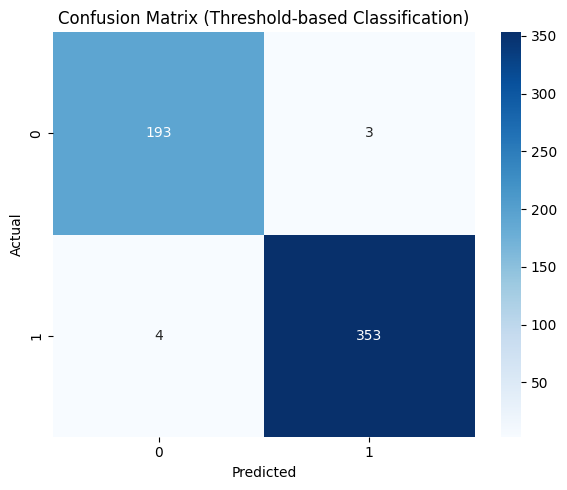

Accuracy: 0.9873417721518988
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       196
           1       0.99      0.99      0.99       357

    accuracy                           0.99       553
   macro avg       0.99      0.99      0.99       553
weighted avg       0.99      0.99      0.99       553



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# 1. Load data
df = pd.read_csv("/content/AAPL.csv")  # Load from the specified path
df['Date'] = pd.to_datetime(df['Date'])
print("✅ Step 1: Data loaded\n", df.head())

# 2. Keep necessary columns
df = df[['Date', 'Open', 'High', 'Low', 'Close(t)', 'Volume']].copy()
print("\n✅ Step 2: Kept necessary columns\n", df.head())

# 3. Handle outliers
for col in ['Open', 'High', 'Low', 'Close(t)', 'Volume']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    median = df[col].median()
    df[col] = df[col].apply(lambda x: median if x < Q1 - 1.5 * IQR or x > Q3 + 1.5 * IQR else x)
print("\n✅ Step 3: Outliers replaced with median\n", df.describe())

# 4. Feature engineering
df['MA5'] = df['Close(t)'].rolling(window=5).mean()
df['MA20'] = df['Close(t)'].rolling(window=20).mean()
df['MA50'] = df['Close(t)'].rolling(window=50).mean()
df['Daily_Return'] = df['Close(t)'].pct_change() * 100
delta = df['Close(t)'].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)
avg_gain = pd.Series(gain).rolling(14).mean()
avg_loss = pd.Series(loss).rolling(14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Handle NaNs after feature engineering before dropping Date
df.fillna(method='ffill', inplace=True)  # Forward fill to handle NaNs
df.dropna(inplace=True)              # Drop any remaining NaNs if necessary
print("\n✅ Step 4: Feature engineering done\n", df.head())


# 5. Drop date
df.drop(columns=['Date'], inplace=True)
print("\n✅ Step 5: Date column dropped\n", df.head())

# 6. Feature scaling
X = df.drop(columns=['Close(t)'])
y = df['Close(t)']
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
print("\n✅ Step 6: Feature scaling done\n", X_scaled.head())

# 7. Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, train_size=0.7, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
print("\n✅ Step 7: Data split into train, validation, test")
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

# 8. Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
print("\n✅ Step 8: Linear Regression model trained")

# 9. Predict and evaluate
y_pred_test = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
print(f"\n✅ Step 9: Evaluation\nMAE = {mae:.2f}, RMSE = {rmse:.2f}, R² = {r2:.2f}")

# 10. Visualize Actual vs. Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred_test, label='Predicted', color='red')
plt.xlabel('Time Index')
plt.ylabel('Closing Price')
plt.title('Actual vs. Predicted Closing Prices')
plt.legend()
plt.grid(True)
plt.show()

# 11. Confusion Matrix (by thresholding regression values)
threshold = y_test.mean()
y_test_cls = (y_test > threshold).astype(int)
y_pred_cls = (y_pred_test > threshold).astype(int)
cm = confusion_matrix(y_test_cls, y_pred_cls)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Threshold-based Classification)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Calculate and print accuracy and classification report
accuracy = accuracy_score(y_test_cls, y_pred_cls)
print("Accuracy:", accuracy)
print(classification_report(y_test_cls, y_pred_cls))